#  MONAI Bootcamp
## Domain shift regression

<img src="https://github.com/Project-MONAI/MONAIBootcamp2021/raw/2f28b64f814a03703667c8ea18cc84f53d6795e4/day1/monai.png" width=400>

This notebook is a brief template to generate synthetic gadolinium-enhanced T1w brain image from FLAIR(Fluid Attenuated Inversion Recovery), T1w and T2w images.

For the sake of speed, a 2D dataset has been created by taking slices from the 3D BRATS brain tumor dataset.

The dataset comes from http://medicaldecathlon.com/.

A number of blanks need to be filled in to get some results, and then improvements can be made to improve upon these!

#### Required Packages 
The servers running MONAI Bootcamp already have CUDA driver, CUDA toolkit 11.0, pytorch 1.6+, monai 0.8.1, and libraries for practice installed.

This notebook has the pip command for installing MONAI and will be added to any subsequent notebook in BYOD or colab environment.

Execute the following cell to install MONAI the first time a colab notebook or your own environment is run:

In [ ]:
#!pip install -qU "monai[ignite, nibabel, torchvision, tqdm]==0.8.1"

### Check GPU 
 Running  `!nvidia-smi` in a cell will verify this has worked and show you what kind of hardware you have access to.
 if GPU Memory Usage is no `0 MiB` shutdown all kernels and restart current kernel.
- step1. shutdown kernel with following <b>Menu</b> > <b>Kernel</b> > <b>Shut Down All kernels </b>
- step2. restart kernelw with following <b>Menu</b> > <b>Kernel</b> > <b>Restart Kernel</b>

In [2]:
!nvidia-smi

Sat Nov  5 04:13:50 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 515.65.01    Driver Version: 515.65.01    CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100-SXM...  On   | 00000000:87:00.0 Off |                   On |
| N/A   35C    P0    61W / 400W |     41MiB / 81920MiB |     N/A      Default |
|                               |                      |              Enabled |
+-------------------------------+----------------------+----------------------+

+-----------------------------------------------------------------------------+
| MIG d

### Setup imports

In [3]:
import random
from tqdm import trange
import os
from glob import glob
import numpy as np
import matplotlib.pyplot as plt
import torch
from monai.apps import download_and_extract
from monai.config import print_config
from monai.data import Dataset, DataLoader, partition_dataset
from monai.networks import eval_mode
from monai.transforms import (
    Compose,
    EnsureTyped,
    LoadImaged,
    MapTransform,
    rescale_array,
    ScaleIntensityd,
)
from monai.utils import set_determinism

print_config()
set_determinism(0)

MONAI version: 0.9.1
Numpy version: 1.22.0
Pytorch version: 1.11.0a0+bfe5ad2
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: 356d2d2f41b473f588899d705bbc682308cee52c
MONAI __file__: /opt/conda/lib/python3.8/site-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: 0.4.9
Nibabel version: 4.0.1
scikit-image version: 0.19.3
Pillow version: 9.2.0
Tensorboard version: 2.10.0
gdown version: 4.5.1
TorchVision version: 0.12.0a0
tqdm version: 4.62.3
lmdb version: 1.3.0
psutil version: 5.9.0
pandas version: 1.3.5
einops version: 0.4.1
transformers version: 4.21.3
mlflow version: NOT INSTALLED or UNKNOWN VERSION.
pynrrd version: 0.4.3

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



## 1. Setting up our Dataset and exploring the data
#### Setup data directory

We'll create a temporary directory for all the MONAI data we're going to be using called temp directory in `~/monai-lab/temp`. 

In [4]:
import os 
directory = "temp"
if not os.path.exists(directory):
    os.makedirs(directory)
root_dir = tempfile.mkdtemp() if directory is None else directory
print(root_dir)

temp


In [5]:
resource = "https://drive.google.com/uc?id=17f4J_rU5pi1zRmxMe5OwljyT3tlBf6qI&confirm=no_antivirus"
data_dir = os.path.join(root_dir, "brain_2d")
compressed_file = os.path.join(root_dir, "brain_2d.tar.gz")
print(data_dir)
if not os.path.exists(data_dir):
    download_and_extract(resource, compressed_file, root_dir)

temp/brain_2d


### visualize dataset

In [6]:
input_ims = sorted(glob(os.path.join(data_dir, "*input.npy")))
output_ims = sorted(glob(os.path.join(data_dir, "*GT_output.npy")))
data = [{"input": i, "output": o} for i, o in zip(input_ims, output_ims)]
print("number data points", len(data))
print("example", data[0])

number data points 7500
example {'input': 'temp/brain_2d/0_input.npy', 'output': 'temp/brain_2d/0_GT_output.npy'}


In [7]:
data_sample = np.load('temp/brain_2d/0_input.npy')
gt_sample = np.load('temp/brain_2d/0_GT_output.npy')

In [8]:
print("data shape:", data_sample.shape, gt_sample.shape)

data shape: (3, 240, 240) (1, 240, 240)


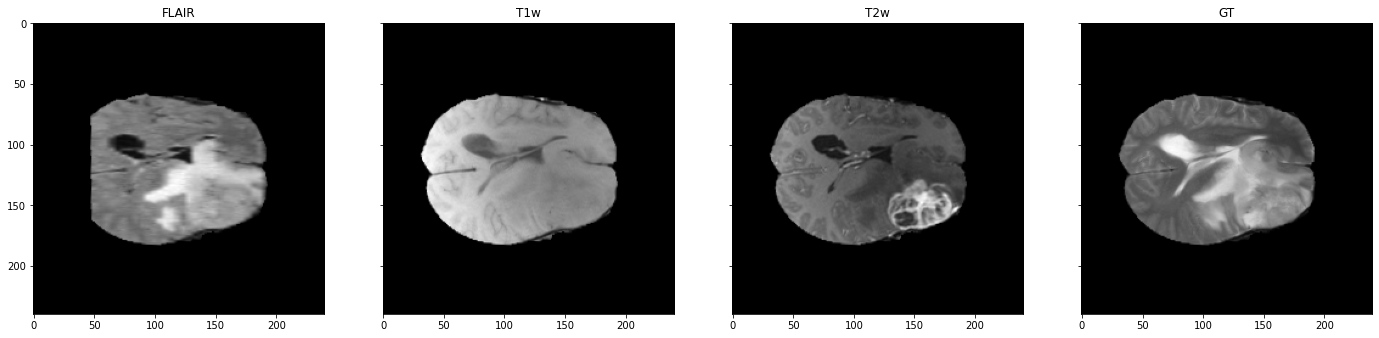

In [9]:
import matplotlib.pyplot as plt

fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4 ,  sharex=True, sharey=True, figsize=(24,6))

ax1.imshow(data_sample[0], cmap='gray' )
ax1.set_title('FLAIR')
ax2.imshow(data_sample[1], cmap='gray' )
ax2.set_title('T1w')
ax3.imshow(data_sample[2], cmap='gray' )
ax3.set_title('T2w')
ax4.imshow(gt_sample[0], cmap='gray' )
ax4.set_title('GT')
plt.show()


## split dataset( train / valid 20%)

In [9]:
class ChannelWiseScaleIntensityd(MapTransform):
    """Perform channel-wise intensity normalisation."""
    def __init__(self, keys):
        super().__init__(keys)
    def __call__(self, d):
        for key in self.keys:
            for idx, channel in enumerate(d[key]):
                d[key][idx] = rescale_array(channel)
        return d

keys = ["input", "output"]
train_transforms = Compose([
    LoadImaged(keys),
    ChannelWiseScaleIntensityd("input"),
    ScaleIntensityd("output"),
    EnsureTyped(keys),
])
val_transforms = Compose([
    LoadImaged(keys),
    ChannelWiseScaleIntensityd("input"),
    ScaleIntensityd("output"),
    EnsureTyped(keys),
])

t = train_transforms(data[0])
print(t["input"].shape, t["output"].shape)
in_channels, out_channels = t["input"].shape[0], t["output"].shape[0]

(3, 240, 240) (1, 240, 240)


In [10]:
# split data into 80% and 20% for training and validation, respectively
train_data, val_data = partition_dataset(data, (8, 2), shuffle=True)
print("num train data points:", len(train_data))
print("num val data points:", len(val_data))
batch_size = 40 ##### default 10 1GB, AE : 40 2GiB
num_workers = 4 ###### default 10 
train_ds = Dataset(train_data, train_transforms)
train_dl = DataLoader(train_ds, num_workers=num_workers, batch_size=batch_size, shuffle=True)
val_ds = Dataset(val_data, val_transforms)
val_dl = DataLoader(val_ds, num_workers=num_workers, batch_size=batch_size, shuffle=True)

num train data points: 6000
num val data points: 1500


In [11]:
%matplotlib inline
def imshows(ims):
    """Visualises a list of dictionaries.

    Each key of the dictionary will be used as a column, and
    each element of the list will be a row.
    """
    nrow = len(ims)
    ncol = len(ims[0])
    fig, axes = plt.subplots(nrow, ncol, figsize=(
        ncol * 4, nrow * 4), facecolor='white')
    for i, im_dict in enumerate(ims):
        for j, (title, im) in enumerate(im_dict.items()):
            if isinstance(im, torch.Tensor):
                im = im.detach().cpu().numpy()
            # If RGB, put to end. Else, average across channel dim
            if im.ndim > 2:
                im = np.moveaxis(im, 0, -1) if im.shape[0] == 3 else np.mean(im, axis=0)

            ax = axes[j] if len(ims) == 1 else axes[i, j]
            ax.set_title(f"{title}\n{im.shape}")
            im_show = ax.imshow(im, cmap='gray')
            ax.axis("off")



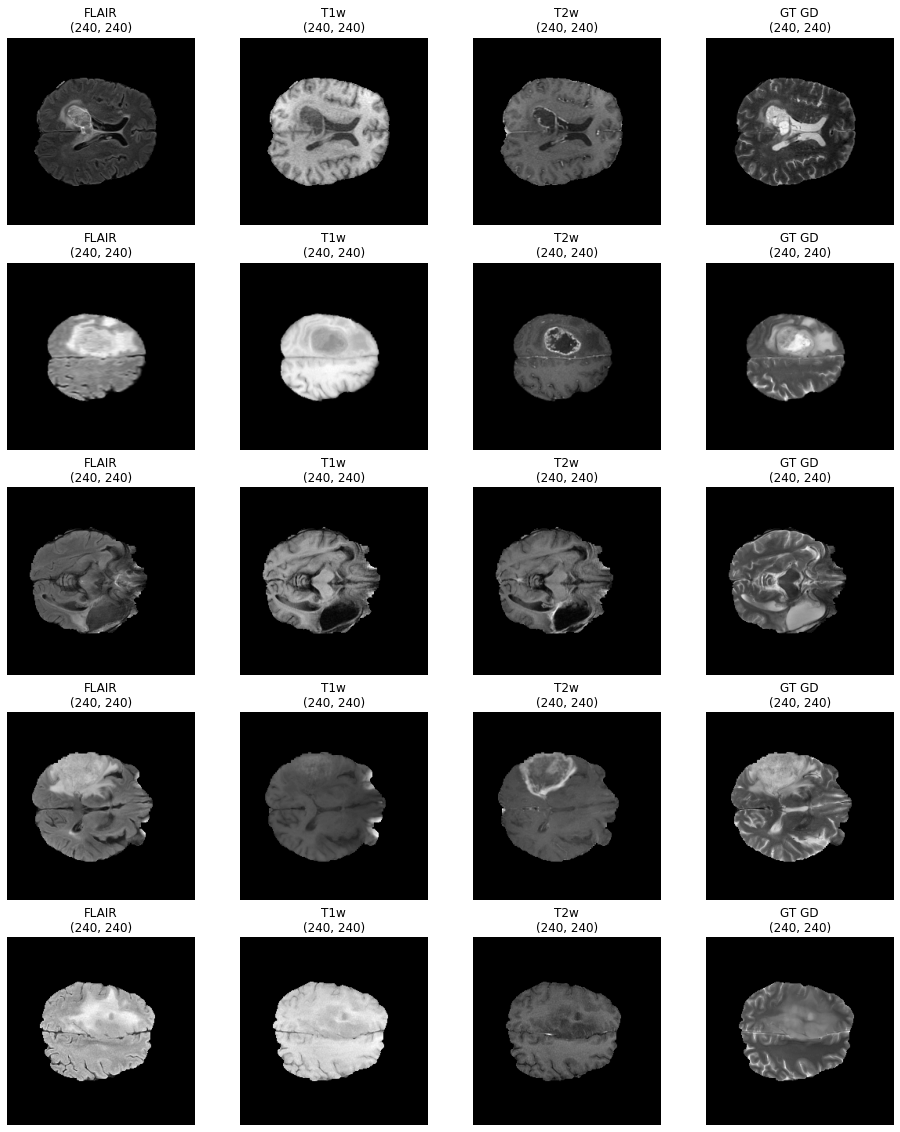

In [12]:
to_imshow = []
for idx in np.random.choice(len(val_ds), size=5, replace=False):
    rand_data = val_ds[idx]
    rand_input, rand_output_gt = rand_data["input"], rand_data["output"]

    to_imshow.append(
        {
            "FLAIR": rand_input[0],
            "T1w": rand_input[1],
            "T2w": rand_input[2],
            "GT GD": rand_output_gt,

        }
    )
imshows(to_imshow)

In [13]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 
warnings.filterwarnings("ignore", category=UserWarning) 


### Template for train

#### configure model

In [17]:
device = "cuda" if torch.cuda.is_available() else "cpu"

# Create loss fn and optimiser

model = None  # TODO


print(model)

None


#### train script script 

In [16]:
max_epochs = 10  #None  # TODO
loss_function = None  # TODO
optimizer = None  # TODO
epoch_losses = []

t = trange(max_epochs, desc=f"epoch 0, avg loss: inf", leave=True)
for epoch in t:
    model.train()
    epoch_loss = 0
    step = 0
    for batch in train_dl:
        step += 1
        inputs, outputs_gt = batch["input"].to(device), batch["output"].to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_function(outputs, outputs_gt)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    epoch_loss /= step
    epoch_losses.append(epoch_loss)
    t.set_description(f"epoch {epoch + 1}, average loss: {epoch_loss:.4f}")

epoch 0, avg loss: inf:   0%|          | 0/10 [00:00<?, ?it/s]


AttributeError: 'NoneType' object has no attribute 'train'

### Monai Network
MONAI provides predefined networks. we can easily import it. 

- [Layers](https://docs.monai.io/en/stable/networks.html#layers) : Act, Conv, Norm, Dropout, Flatten, Reshape, Pad, Pool, SkipConnection
- [Blocks](https://docs.monai.io/en/stable/networks.html#module-monai.networks.blocks) : ADN, Convolution, Synamic UnetBlock, FCN, GCN, Squeeze-andExcitation, ResNeXt, SABlock, Transformer Block, 
- [Nets](https://docs.monai.io/en/stable/networks.html#nets)  : DenseNet121, EfficientNet, SegResNet, ResNet, SENet154, DyUNet, UNet, AutoEncoder, VarAutoEncoder, ViT, 

### Model 1. AutoEncoder

<img align='left' src="https://miro.medium.com/max/1400/1*nGFy96r63GwSE_EsJDLMDw.png" width=600>   - 4 layers with  `[4, 8, 16, 32]` channels 
 


image from [medium blog ](https://medium.com/geekculture/variational-autoencoder-vae-9b8ce5475f68)


In [18]:
device = "cuda" if torch.cuda.is_available() else "cpu"


from monai.networks.nets import AutoEncoder

model = AutoEncoder(
    spatial_dims =2,
    in_channels=in_channels,
    out_channels=out_channels,
    channels=(4, 8, 16, 32),
    strides=(2, 2, 2, 2),
).to(device)  # TODO



In [19]:
print(model)

AutoEncoder(
  (encode): Sequential(
    (encode_0): Convolution(
      (conv): Conv2d(3, 4, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (adn): ADN(
        (N): InstanceNorm2d(4, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
        (A): PReLU(num_parameters=1)
      )
    )
    (encode_1): Convolution(
      (conv): Conv2d(4, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (adn): ADN(
        (N): InstanceNorm2d(8, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
        (A): PReLU(num_parameters=1)
      )
    )
    (encode_2): Convolution(
      (conv): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (adn): ADN(
        (N): InstanceNorm2d(16, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
        (A): PReLU(num_parameters=1)
      )
    )
    (encode_3): Convolution(
      (conv): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (adn): ADN(
        (N): In

In [20]:
# Create loss fn and optimiser


loss_function = torch.nn.MSELoss() # TODO

learning_rate = 1e-3
optimizer = torch.optim.Adam(model.parameters(), learning_rate)  # TODO


In [21]:
max_epochs = 20  #None  # TODO

It will take more 10 minutes to finish 20 epoch training. it depends on system.

In [22]:
%%time
epoch_losses = []

t = trange(max_epochs, desc=f"epoch 0, avg loss: inf", leave=True)
for epoch in t:
    model.train()
    epoch_loss = 0
    step = 0
    for batch in train_dl:
        step += 1
        inputs, outputs_gt = batch["input"].to(device), batch["output"].to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_function(outputs, outputs_gt)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    epoch_loss /= step
    epoch_losses.append(epoch_loss)
    t.set_description(f"epoch {epoch + 1}, average loss: {epoch_loss:.4f}")
    if (epoch+1) % 10 == 0: 
        torch.save(model.state_dict(), os.path.join(root_dir, "gan_ae1_model_{:04d}.pth".format(epoch+1)))
        torch.save(optimizer.state_dict(), os.path.join(root_dir, "gan_ae1_optim_{:04d}.pth".format(epoch+1)))
        #print("|{}ep model saved".format(epoch+1), end='')    

epoch 20, average loss: 0.0047: 100%|██████████| 20/20 [06:45<00:00, 20.28s/it]

CPU times: user 2min 5s, sys: 48.5 s, total: 2min 54s
Wall time: 6min 45s


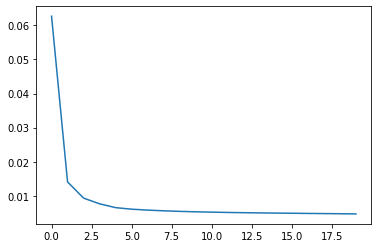

In [23]:
plt.plot(epoch_losses)

In [33]:
%matplotlib inline
def imshows(ims):
    """Visualises a list of dictionaries.

    Each key of the dictionary will be used as a column, and
    each element of the list will be a row.
    """
    nrow = len(ims)
    ncol = len(ims[0])
    fig, axes = plt.subplots(nrow, ncol, figsize=(
        ncol * 3, nrow * 3), facecolor='white')
    for i, im_dict in enumerate(ims):
        for j, (title, im) in enumerate(im_dict.items()):
            if isinstance(im, torch.Tensor):
                im = im.detach().cpu().numpy()
            # If RGB, put to end. Else, average across channel dim
            if im.ndim > 2:
                im = np.moveaxis(im, 0, -1) if im.shape[0] == 3 else np.mean(im, axis=0)

            ax = axes[j] if len(ims) == 1 else axes[i, j]
            ax.set_title(f"{title}\n{im.shape}")
            im_show = ax.imshow(im, cmap='gray')
            ax.axis("off")
            
def inference_gan(model, num_data=4):
    to_imshow = []
    with torch.no_grad():    
        for idx in np.random.choice(len(val_ds), size=num_data, replace=False):
            rand_data = val_ds[idx]
            rand_input, rand_output_gt = rand_data["input"], rand_data["output"]
            rand_output = model(rand_input.to(device)[None])[0]
            to_imshow.append(
                {
                    "FLAIR": rand_input[0],
                    "T1w": rand_input[1],
                    "T2w": rand_input[2],
                    "GT GD": rand_output_gt,
                    "inferred GD": rand_output,
                }
            )
    imshows(to_imshow)      

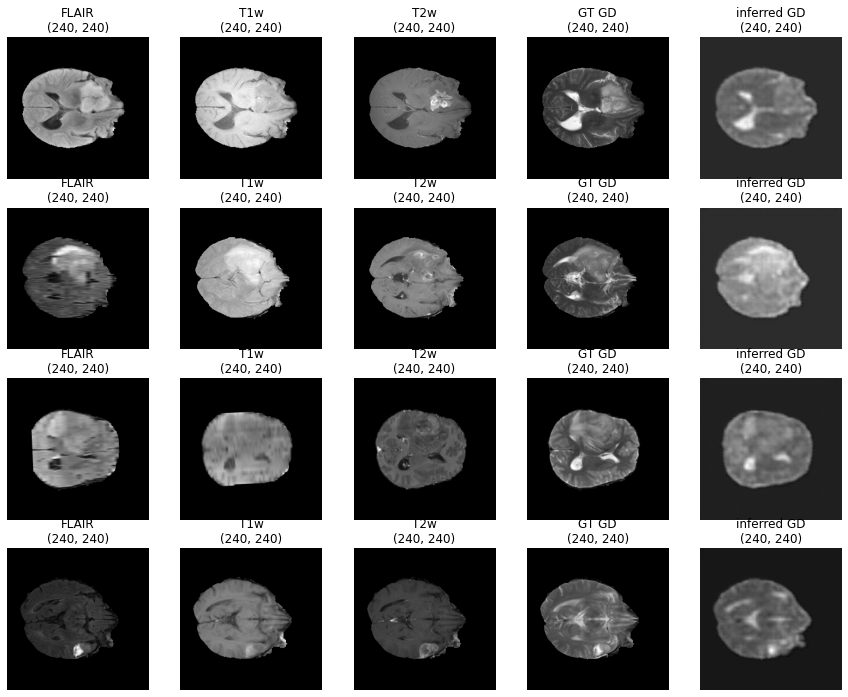

In [25]:
 inference_gan(model, num_data=4)

## evaluate from pretrained model

in `saved` directory, we have pretrained model with 100 epoches with same configuration
with `inference_epoch` function, load checkpoint and inference it. 

In [23]:
def inference_gan_epoch(work_dir, model,  prefix='ae1', epoch=10, num_data=2):
    import torch
    model.load_state_dict(torch.load(os.path.join(work_dir, "gan_{}_model_{:04d}.pth".format(prefix, epoch))))
    model.eval()
    inference_gan(model,   num_data)


- model 1. auto encoder 
- directory : `saved`
- prefix : `ae1`
- model : `monai AutoEncoder`
- channels : `(4, 8, 16, 32)`
- stride  : `(2, 2, 2, 2)`
- epochs : 100,200

In [27]:
model = AutoEncoder(
    spatial_dims =2,
    in_channels=in_channels,
    out_channels=out_channels,
    channels=(4, 8, 16, 32),
    strides=(2, 2, 2, 2),
).to(device)  # TODO


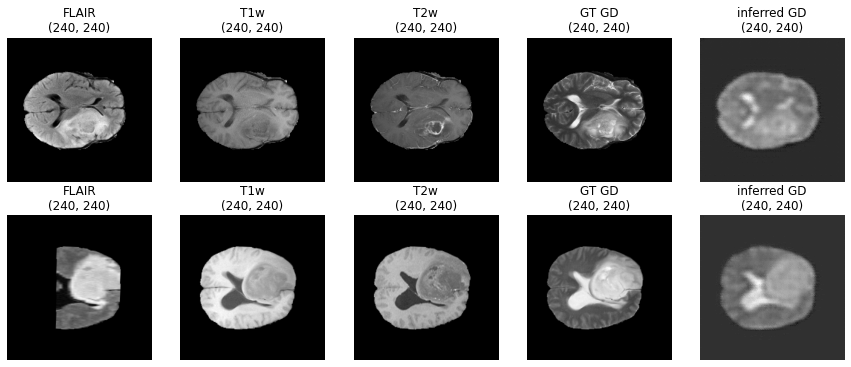

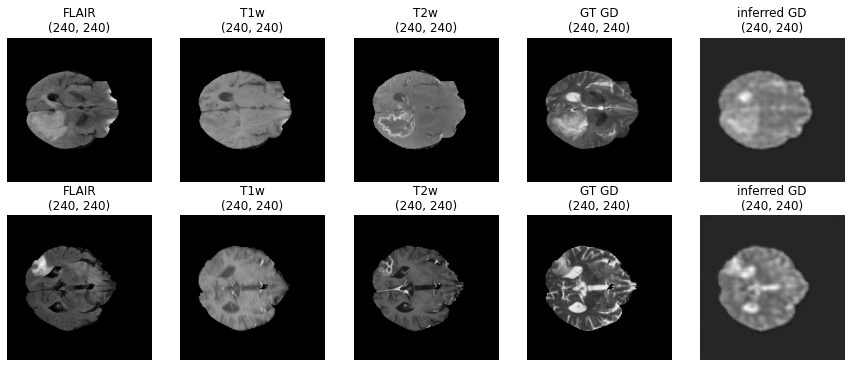

In [28]:
inference_gan_epoch('temp', model,  'ae1', 10, 2)
inference_gan_epoch('temp', model,  'ae1', 20, 2)

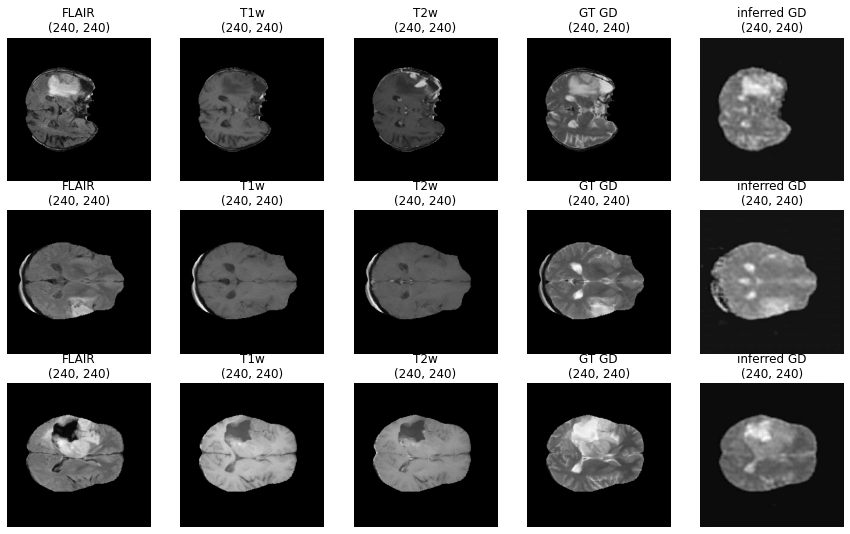

In [29]:
inference_gan_epoch('saved', model,  'ae1', 200, 3)

### Model 2. Auto Encoder with more channels

<img align='left' src="https://miro.medium.com/max/1400/1*nGFy96r63GwSE_EsJDLMDw.png" width=600>

 - 4 layers with  `[8, 16, 32, 64]` channels

In [30]:
device = "cuda" if torch.cuda.is_available() else "cpu"

 
from monai.networks.nets import AutoEncoder

# 4 layers 
model = AutoEncoder(
    spatial_dims =2,
    in_channels=in_channels,
    out_channels=out_channels,
    channels=(8, 16, 32, 64),
    strides=(2, 2, 2, 2),
).to(device)  # TODO


In [31]:
print(model)

AutoEncoder(
  (encode): Sequential(
    (encode_0): Convolution(
      (conv): Conv2d(3, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (adn): ADN(
        (N): InstanceNorm2d(8, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
        (A): PReLU(num_parameters=1)
      )
    )
    (encode_1): Convolution(
      (conv): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (adn): ADN(
        (N): InstanceNorm2d(16, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
        (A): PReLU(num_parameters=1)
      )
    )
    (encode_2): Convolution(
      (conv): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (adn): ADN(
        (N): InstanceNorm2d(32, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
        (A): PReLU(num_parameters=1)
      )
    )
    (encode_3): Convolution(
      (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (adn): ADN(
        (N):

In [32]:
# Create loss fn and optimiser

loss_function = torch.nn.MSELoss() # TODO

learning_rate = 2e-3
optimizer = torch.optim.Adam(model.parameters(), learning_rate)  # TODO


In [33]:
max_epochs = 20  #None  # TODO

In [34]:

epoch_losses = []

t = trange(max_epochs, desc=f"epoch 0, avg loss: inf", leave=True)
for epoch in t:
    model.train()
    epoch_loss = 0
    step = 0
    for batch in train_dl:
        step += 1
        inputs, outputs_gt = batch["input"].to(device), batch["output"].to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_function(outputs, outputs_gt)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    epoch_loss /= step
    epoch_losses.append(epoch_loss)
    t.set_description(f"epoch {epoch + 1}, average loss: {epoch_loss:.4f}")
    if (epoch+1) % 10 == 0: 
        torch.save(model.state_dict(), os.path.join(root_dir, "gan_ae2_model_{:04d}.pth".format(epoch+1)))
        torch.save(optimizer.state_dict(), os.path.join(root_dir, "gan_ae2_optim_{:04d}.pth".format(epoch+1)))
        #print("|{}ep model saved".format(epoch+1), end='')
        

epoch 20, average loss: 0.0035: 100%|██████████| 20/20 [06:46<00:00, 20.34s/it]


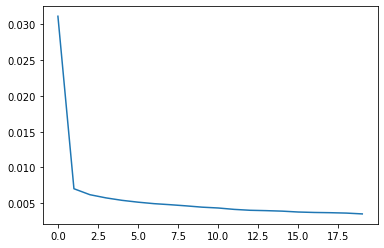

In [35]:
plt.plot(epoch_losses);

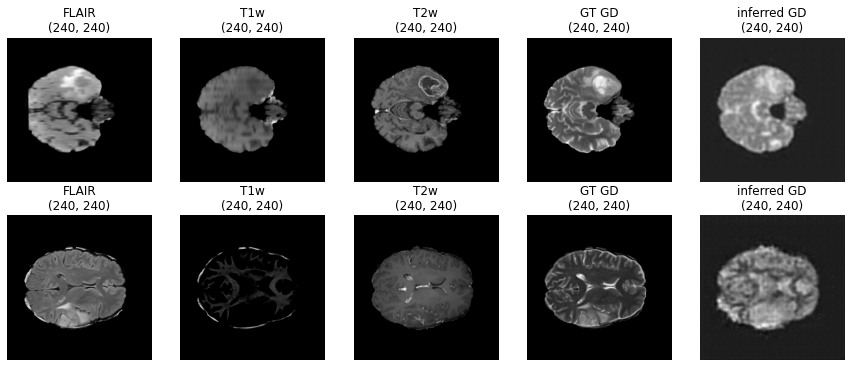

In [36]:
inference_gan(model,   num_data=2)

#### inference with pretrained model

- model 2. auto encoder 
- directory : `saved`
- prefix : `ae2`
- model : `monai AutoEncoder`
- channels : `(8, 16, 32, 64)`
- stride  : `(2, 2, 2, 2)`
- epochs : 100, 200

In [37]:
model = AutoEncoder(
    spatial_dims =2,
    in_channels=in_channels,
    out_channels=out_channels,
    channels=(8, 16, 32, 64),
    strides=(2, 2, 2, 2),
).to(device)  # TODO

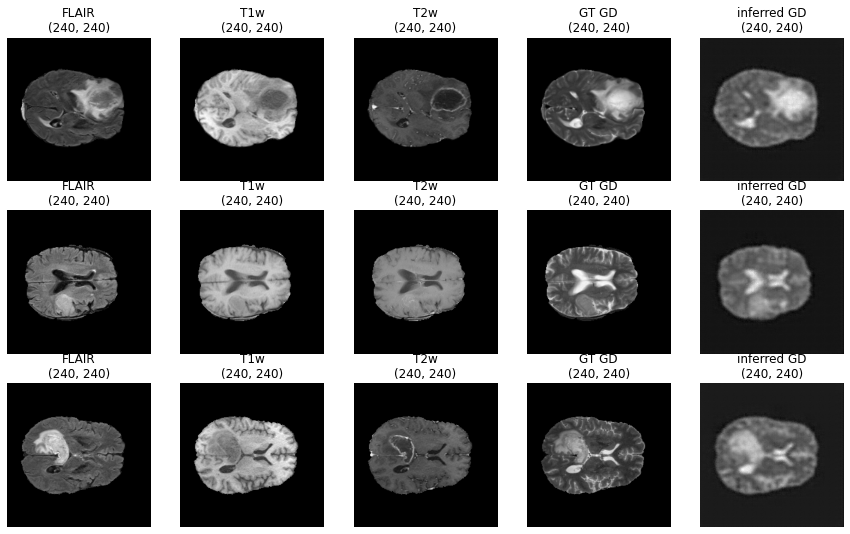

In [38]:
inference_gan_epoch('temp', model,  'ae2', 10, 3)

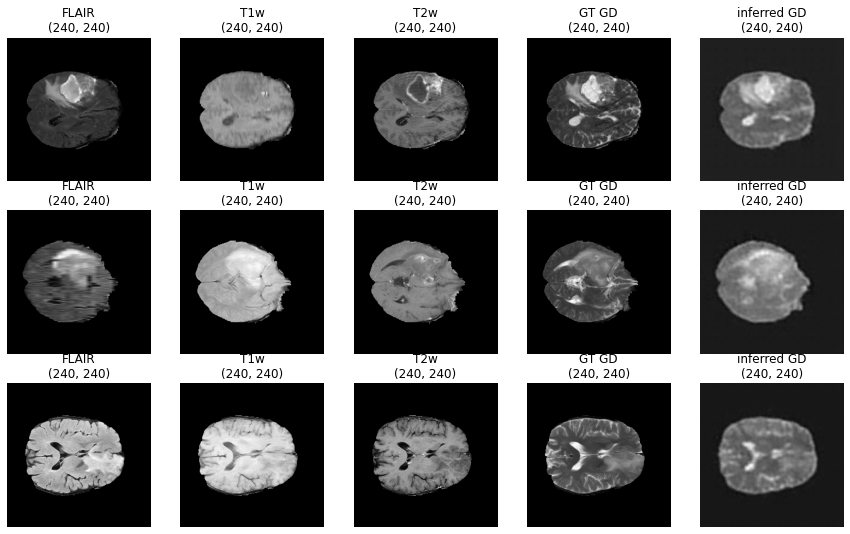

In [39]:
inference_gan_epoch('temp', model,  'ae2', 20, 3)

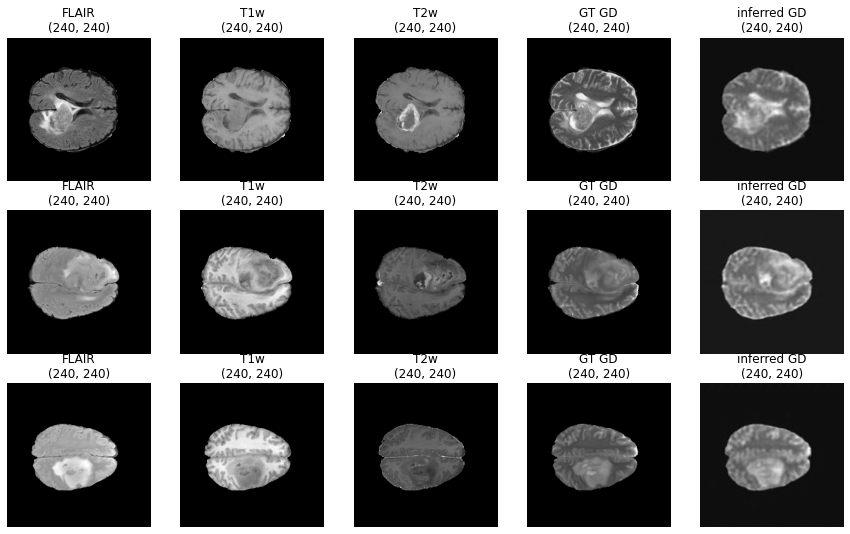

In [40]:
inference_gan_epoch('saved', model,  'ae2', 200 , 3)

### Model 3. UNet

[U-Net: Convolutional Networks for Biomedical Image Segmentation](https://arxiv.org/abs/1505.04597)
U Shaped Network was developed by Olaf Ronneberger et al. for Bio Medical Image Segmentation. 
It is Fully Convolutional Network Model for the segmentation task with two paths(encoder and decoder) with 1x1 convolution skip connection similar as residual. 

<img src="https://miro.medium.com/max/1400/1*J3t2b65ufsl1x6caf6GiBA.png" width=800>

#### UNet in monai.networks
class monai.networks.nets.<b>UNet </b> (`spatial_dims, in_channels, out_channels, channels, strides, kernel_size=3, up_kernel_size=3, num_res_units=0, act='PRELU', norm='INSTANCE', dropout=0.0, bias=True, dimensions=None` )
Enhanced version of <br>UNet</b> which has residual units implemented with the `ResidualUnit` class. The residual part uses a convolution to change the input dimensions to match the output dimensions if this is necessary but will use `nn.Identity` if not. Refer to: [Link](https://link.springer.com/chapter/10.1007/978-3-030-12029-0_40).

Each layer of the network has a encode and decode path with a skip connection between them. Data in the encode path is downsampled using strided convolutions (if strides is given values greater than 1) and in the decode path upsampled using strided transpose convolutions. These down or up sampling operations occur at the beginning of each block rather than afterwards as is typical in <b>UNet</b> implementations.

To further explain this consider the first example network given below. This network has 3 layers with strides of 2 for each of the middle layers (the last layer is the bottom connection which does not down/up sample). Input data to this network is immediately reduced in the spatial dimensions by a factor of 2 by the first convolution of the residual unit defining the first layer of the encode part. The last layer of the decode part will upsample its input (data from the previous layer concatenated with data from the skip connection) in the first convolution. this ensures the final output of the network has the same shape as the input.

Padding values for the convolutions are chosen to ensure output sizes are even divisors/multiples of the input sizes if the strides value for a layer is a factor of the input sizes. A typical case is to use strides values of 2 and inputs that are multiples of powers of 2. An input can thus be downsampled evenly however many times its dimensions can be divided by 2, so for the example network inputs would have to have dimensions that are multiples of 4. In the second example network given below the input to the bottom layer will have shape `(1, 64, 15, 15)` for an input of shape `(1, 1, 240, 240)` demonstrating the input being reduced in size spatially by 2**4.

##### Parameters
 - <b>spatial_dims </b>(`int`)  – number of spatial dimensions.
 - <b>in_channels </b>(`int`) – number of input channels.
 - <b>out_channels </b>(`int`) – number of output channels.
 - <b>channels</b> (`Sequence[int]`) – sequence of channels. Top block first. The length of channels should be no less than 2.
 - <b>strides</b> (`Sequence[int]`) – sequence of convolution strides. The length of stride should equal to len(channels) - 1.
 - <b>kernel_size</b> (`Union[Sequence[int], int]`) – convolution kernel size, the value(s) should be odd. If sequence, its length should equal to dimensions. Defaults to 3.
 - <b>up_kernel_size</b> (`Union[Sequence[int], int]`) – upsampling convolution kernel size, the value(s) should be odd. If sequence, its length should equal to dimensions. Defaults to 3.
 - <b>num_res_units</b>  (`int`)– number of residual units. Defaults to 0.
 - <b>act</b> (`Union[Tuple, str]`) – activation type and arguments. Defaults to PReLU.
 - <b>norm</b> (`Union[Tuple, str]`) – feature normalization type and arguments. Defaults to instance norm.
 - <b>dropout</b> (`float`) – dropout ratio. Defaults to no dropout.
 - <b>bias (`bool`)</b> – whether to have a bias term in convolution blocks. Defaults to True. According to Performance Tuning Guide, if a conv layer is directly followed by a batch norm layer, bias should be False.

In [14]:
device = "cuda" if torch.cuda.is_available() else "cpu"

from monai.networks.nets import UNet

# 4 layers 
model = UNet(
    spatial_dims =2,
    in_channels=in_channels,
    out_channels=out_channels,
    channels=(4, 8, 16, 32, 64),
    strides=(2, 2, 2, 2),
).to(device)  # TODO


In [15]:
# Create loss fn and optimiser

loss_function = torch.nn.MSELoss() # TODO

learning_rate = 1e-3
optimizer = torch.optim.Adam(model.parameters(), learning_rate)  # TODO

In [16]:
max_epochs = 20  #None  # TODO

In [17]:
print(model)

UNet(
  (model): Sequential(
    (0): Convolution(
      (conv): Conv2d(3, 4, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (adn): ADN(
        (N): InstanceNorm2d(4, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
        (D): Dropout(p=0.0, inplace=False)
        (A): PReLU(num_parameters=1)
      )
    )
    (1): SkipConnection(
      (submodule): Sequential(
        (0): Convolution(
          (conv): Conv2d(4, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (adn): ADN(
            (N): InstanceNorm2d(8, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
            (D): Dropout(p=0.0, inplace=False)
            (A): PReLU(num_parameters=1)
          )
        )
        (1): SkipConnection(
          (submodule): Sequential(
            (0): Convolution(
              (conv): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
              (adn): ADN(
                (N): InstanceNorm2d(16, eps=1e-05, momentu

In [18]:

epoch_losses = []

t = trange(max_epochs, desc=f"epoch 0, avg loss: inf", leave=True)
for epoch in t:
    model.train()
    epoch_loss = 0
    step = 0
    for batch in train_dl:
        step += 1
        inputs, outputs_gt = batch["input"].to(device), batch["output"].to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_function(outputs, outputs_gt)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    epoch_loss /= step
    epoch_losses.append(epoch_loss)
    
    if (epoch+1) % 10 == 0: 
        torch.save(model.state_dict(), os.path.join(root_dir, "gan_unet_model_{:04d}.pth".format(epoch+1)))
        torch.save(optimizer.state_dict(), os.path.join(root_dir, "gan_unet_optim_{:04d}.pth".format(epoch+1)))
        #print("|{}ep model saved".format(epoch+1), end='')
        
    t.set_description(f"epoch {epoch + 1}, average loss: {epoch_loss:.4f}")

epoch 20, average loss: 0.0042: 100%|██████████| 20/20 [07:47<00:00, 23.40s/it]


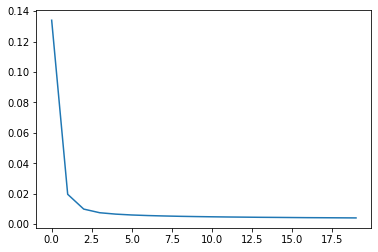

In [19]:
plt.plot(epoch_losses);

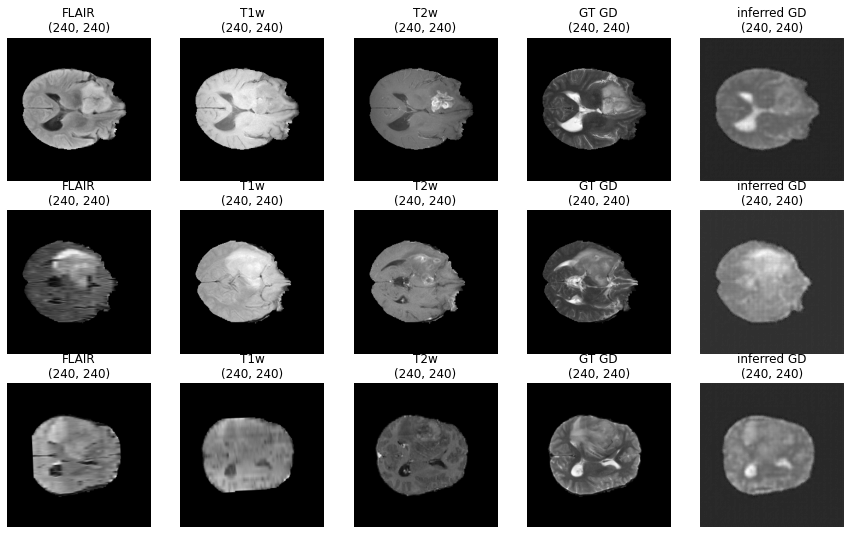

In [25]:
inference_gan(model,   num_data=3)

### inference with pre-trained model



- model 3. Unet  
- directory : `saved`
- prefix : `unet`
- model : `monai UNet`
- channels : `(4, 8, 16, 32, 64)`
- stride  : `(2, 2, 2, 2)`
- epochs : 200,1000



In [26]:
model = UNet(
    spatial_dims =2,
    in_channels=in_channels,
    out_channels=out_channels,
    channels=(4, 8, 16, 32, 64),
    strides=(2, 2, 2, 2),
).to(device)  # TODO

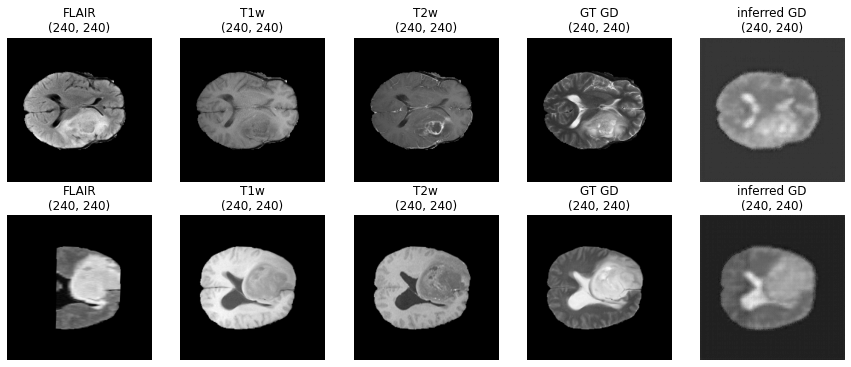

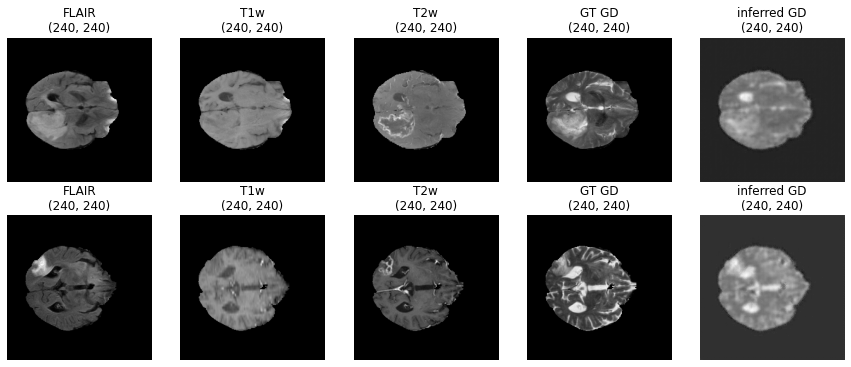

In [27]:
inference_gan_epoch('temp', model,  'unet', 10, 2)
inference_gan_epoch('temp', model,  'unet', 20, 2)

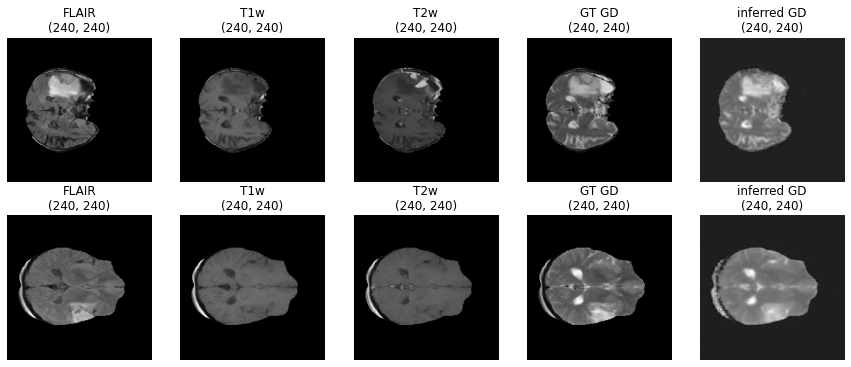

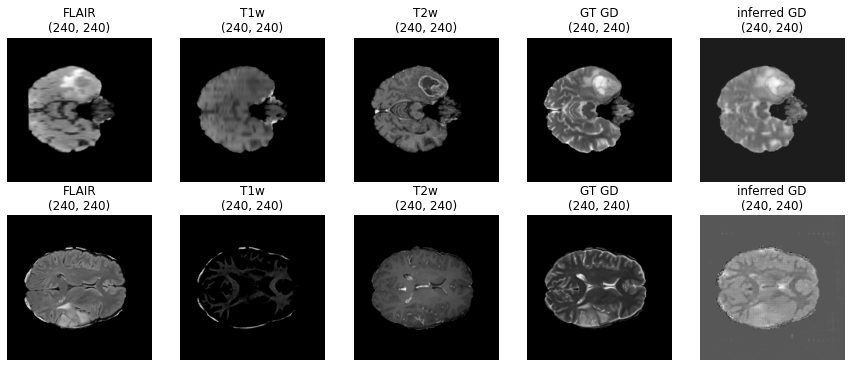

In [28]:
inference_gan_epoch('saved', model,  'unet', 200, 2)
inference_gan_epoch('saved', model,  'unet', 1000, 2)

# enable AMP (Optinal)
Deep Neural Network training has traditionally relied on IEEE single-precision format, however with mixed precision, you can train with half precision while maintaining the network accuracy achieved with single precision. This technique of using both single- and half-precision representations is referred to as mixed precision technique. Mixed precision methods combine the use of different numerical formats in one computational workload. 

### Benefits of Mixed precision training
- Speeds up math-intensive operations, such as linear and convolution layers, by using Tensor Cores.
- Speeds up memory-limited operations by accessing half the bytes compared to single-precision.
- Reduces memory requirements for training models, enabling larger models or larger minibatches.

Enabling mixed precision involves two steps: porting the model to use the half-precision data type where appropriate, and using loss scaling to preserve small gradient values. Deep learning researchers and engineers can easily get started enabling this feature on Ampere, Volta and Turing GPUs.

On Ampere GPUs, automatic mixed precision uses FP16 to deliver a performance boost of 3X versus TF32, the new format which is already ~6x faster than FP32. On Volta and Turing GPUs, automatic mixed precision delivers up to 3X higher performance vs FP32 with just a few lines of code. The best training performance on NVIDIA GPUs is always available on the NVIDIA deep learning performance page.[link1](https://developer.nvidia.com/deep-learning-performance-training-inference) 
[link2](https://docs.nvidia.com/deeplearning/performance/mixed-precision-training/index.html) 

![](https://developer.nvidia.com/sites/default/files/dev-ai-tech-amp-workflow-graphic-950353-r7-web.png)
![precision](https://developer-blogs.nvidia.com/wp-content/uploads/2021/01/AI_training_TF32_tensor_cores_F2.png)

In [29]:
device = "cuda" if torch.cuda.is_available() else "cpu"

# Create loss fn and optimiser
max_epochs = 10  #None  # TODO

from monai.networks.nets import UNet

# 4 layers 
model = UNet(
    spatial_dims =2,
    in_channels=in_channels,
    out_channels=out_channels,
    channels=(4, 8, 16, 32, 64),
    strides=(2, 2, 2, 2),
).to(device)  # TODO

loss_function = torch.nn.MSELoss() # TODO

learning_rate = 1e-3
optimizer = torch.optim.Adam(model.parameters(), learning_rate)  # TODO


with `with autocast(enabled=amp)`, we can enable AMP(Automatic Mixed Precision) with FP16.
pytorch also need scaler for AMP

In [30]:
###### module load for AMP 
from torch.cuda.amp import GradScaler, autocast  ## for AMP 

###### configuration for AMP 
amp = True 

###### scaler for AMP 
if amp is True:
    scaler = GradScaler()
else:
    scaler = None


epoch_losses = []

t = trange(max_epochs, desc=f"epoch 0, avg loss: inf", leave=True)
for epoch in t:
    model.train()
    epoch_loss = 0
    step = 0
    for batch in train_dl:
        step += 1
        inputs, outputs_gt = batch["input"].to(device), batch["output"].to(device)
        optimizer.zero_grad()
        ###### autocast  for AMP in native pytorch
        with autocast(enabled=amp):
            outputs = model(inputs)        
            loss = loss_function(outputs, outputs_gt)
            
        ###### backward with AMP in native pytorch            
        if amp:    
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()            
        else :
            loss.backward()
            optimizer.step()
        epoch_loss += loss.item()
    epoch_loss /= step
    epoch_losses.append(epoch_loss)
    t.set_description(f"epoch {epoch + 1}, average loss: {epoch_loss:.4f}")

epoch 10, average loss: 0.0050: 100%|██████████| 10/10 [03:30<00:00, 21.10s/it]


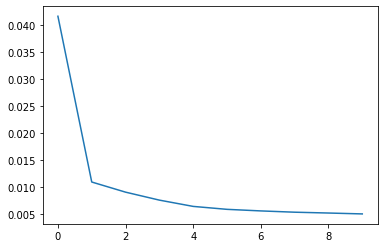

In [31]:
plt.plot(epoch_losses)

IndexError: index 4 is out of bounds for axis 1 with size 4

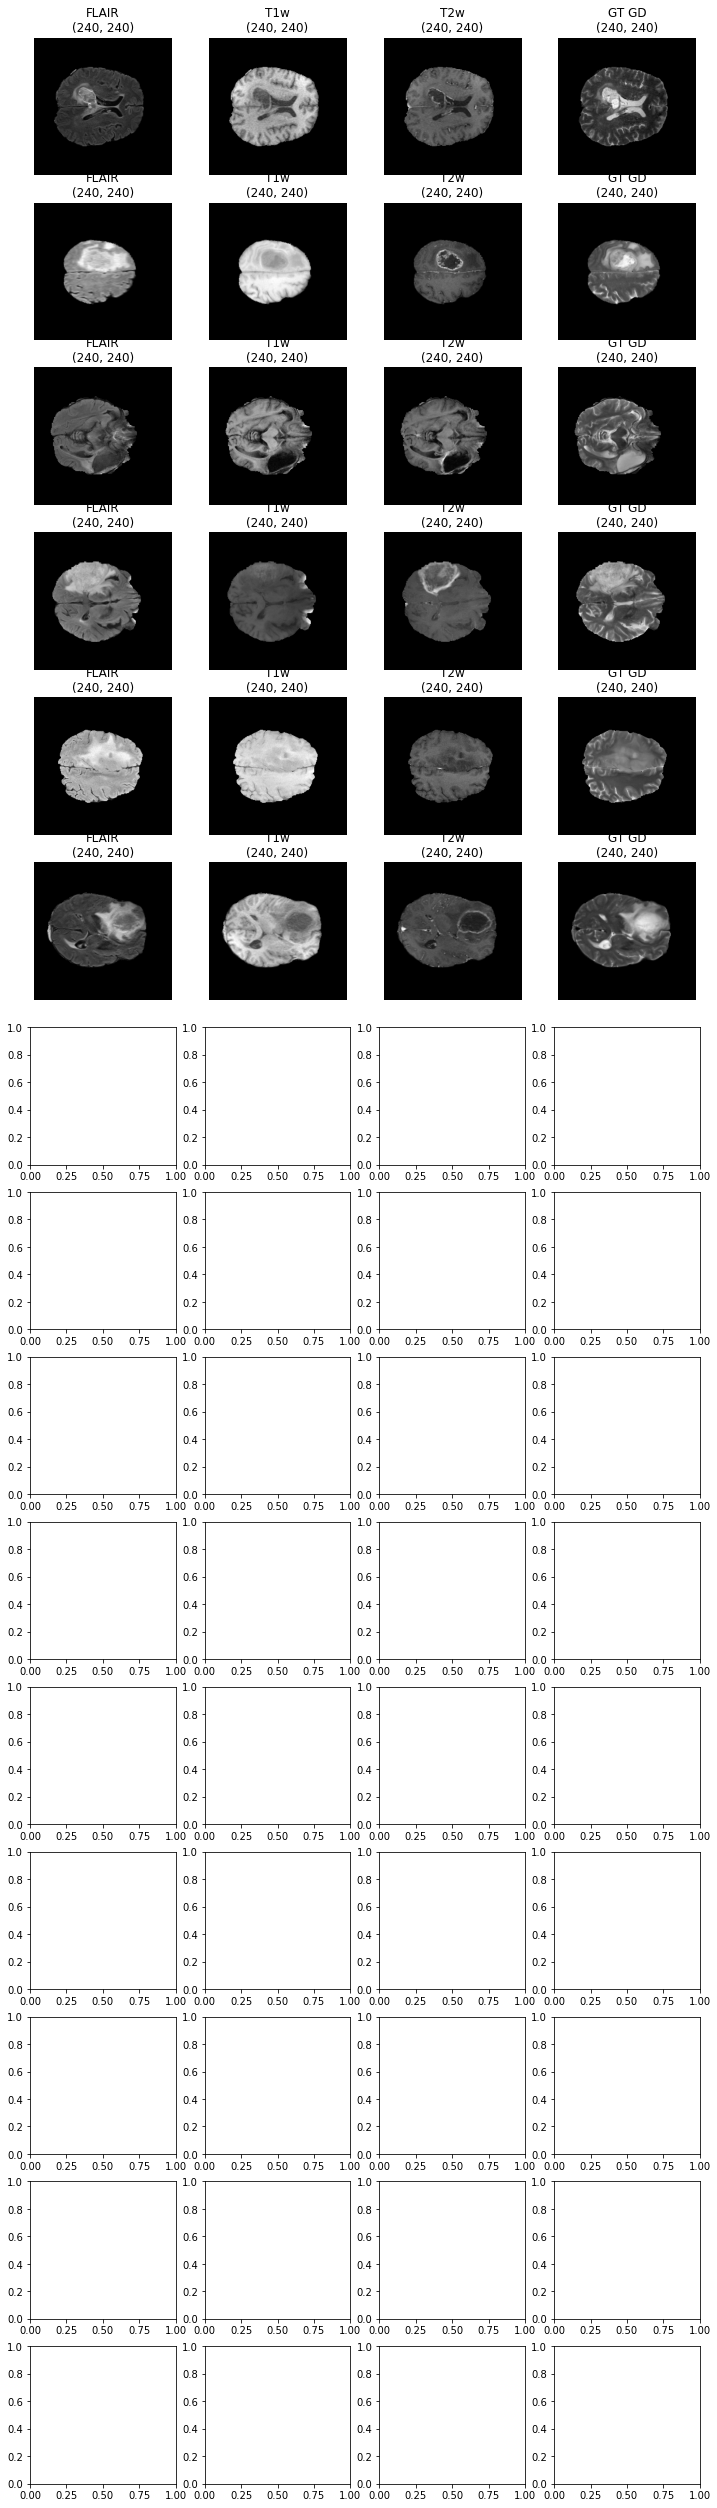

In [34]:
_ = model.eval()

for idx in np.random.choice(len(val_ds), size=5, replace=False):
    rand_data = val_ds[idx]
    rand_input, rand_output_gt = rand_data["input"], rand_data["output"]
    rand_output = model(rand_input.to(device)[None])[0]
        
    to_imshow.append(
        {
            "FLAIR": rand_input[0],
            "T1w": rand_input[1],
            "T2w": rand_input[2],
            "GT GD": rand_output_gt,
            "inferred GD": rand_output,
        }
    )
imshows(to_imshow)

## Caution !!!
### please shutdown all kernels with [Kernel] menu >  [Shutdown All Kernel]  before launch next notebook

## Navigation
- [01_getting started](./01_getting.ipynb)

- [02_pipeline_01](./02_pipeline_01.ipynb)
- [02_pipeline_02 ](./02_pipeline_02.ipynb)
- [02_pipeline_03](./02_pipeline_03.ipynb)
- [02_pipeline_04  ](./02_pipeline_04.ipynb)

- [03_brain_gan ](./03_brain_gan_01.ipynb)

- [04_spleen_segment Next](./04_spleen_segment.ipynb) 

- [05_challenge_cardiac baseline](./05_challenge_cardiac_baseline.ipynb) 

- [05_challenge_cardiac workspace](./05_challenge_cardiac_workspace.ipynb) 

<img src="https://github.com/Project-MONAI/MONAIBootcamp2021/raw/2f28b64f814a03703667c8ea18cc84f53d6795e4/day1/monai.png" width=400>